In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import pickle
from cvxopt import matrix, sparse, solvers

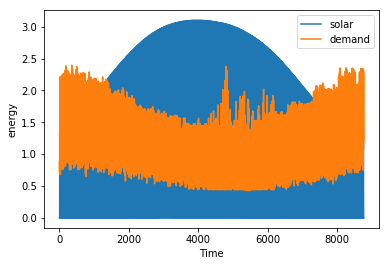

In [2]:
# Data loading and procesing
df = pd.read_csv('processed data.csv')
demand = df['Electricity:Facility [kW](Hourly)'].values
solar = df['Normalized Solar Energy [kWh]'].values

T = 8760
demand = demand[:T]
solar = solar[:T]

solar_extend = np.append(solar,np.zeros(T))
demand_extend = np.append(demand,np.zeros(T))

t = np.arange(1,T+1)
plt.figure()
plt.xlabel('Time')
plt.ylabel('energy')
plt.plot(t,solar,label='solar')
plt.plot(t,demand,label='demand')
plt.legend()
plt.show()

In [4]:
# Parameters
C = 5.
xi = np.array([3.5,3.4,3.2,3.3,3.4,3.3,3.4,4.1,3.8,4.0,4.0,4.4,4.2,4.1,3.9,3.9,4.7,5.6,5.1,4.5,4.0,3.4,3.4,3.0])
xi = np.tile(xi,T//len(xi))
xi_extend = np.append(xi,np.zeros(T))
sigma = 2.5
pi = 3

In [5]:
def inequality_matrix(W=0):
    '''
    This function is meant to form a linear programming (sub)problem
    A: The inequality constraint matrix
    b: The inequality constraint bound
    c: The cost function
    '''
    if W <= 0:
        print('Prediction window too short!')
        A = np.array([])
        return A
    
    elif W >= T:
        W = T
        print('Prediction window longer than time length--consider it as offline!')
        
    else:
        pass
    
    # Define the inequality matrix
    A1 = np.zeros((1*W,3*W))
    A2 = np.zeros((1*W,3*W))
    A3 = np.zeros((1*W,3*W))
    for i in range(W):
        A1[i,i*3] = -1.
        A1[i,i*3+1] = 1.
        A1[i,i*3+2] = -1.
        if i >= 1:
            A2[i,:] = A2[i-1,:]
            A3[i,:] = A3[i-1,:]
        A2[i,i*3+1] = 1.
        A3[i,i*3+1] = -1.
        A2[i,i*3+2] = -1.
        A3[i,i*3+2] = 1.
    A4 = -np.eye(3*W)
    A = np.concatenate((A1, A2), axis=0)
    A = np.concatenate((A, A3), axis=0)
    A = np.concatenate((A, A4), axis=0)  
    return A

In [6]:
def inequality_bound(W=0,t=0,s0=0.):
    '''
    inequality bound is an online variable
    it changes according to time t and starting point s0
    '''
    if W <= 0:
        print('Prediction window too short!')
        b = np.array([])
        return b
    
    elif W >= T:
        print('Prediction window longer than time length--consider it as offline!')
        W = T
        # Define the inequality bound
        b1 = solar - demand
        
    else:
        if t-1>=0:
            b1 = solar_extend[t-1:t+W-1] - demand_extend[t-1:t+W-1]
        else:
            b1 = np.append(solar_extend[t-1:],solar_extend[:t+W-1]) - np.append(demand_extend[t-1:],demand_extend[:t+W-1])
    
    b2 = np.ones(W)*(C-s0)
    b3 = np.ones(W)*(s0)
    b4 = np.zeros(3*W)
    b = np.append(b1,b2)
    b = np.append(b,b3)
    b = np.append(b,b4) 
    
    return b

In [7]:
def cost(W=0,t=0):
    
    if W <= 0:
        print('Prediction window too short!')
        c = np.array([])
        return c
    elif W>=T:
        print('Prediction window longer than time length--consider it as offline!')
        W = T
    else:
        pass
    c = np.zeros(3*W)
    # Define the cost function
    for i in range(W):
        c[3*i] = xi_extend[t-1+i]+sigma
        c[3*i+1] = pi-sigma
        c[3*i+2] = pi+sigma
        
    return c

In [8]:
def transformed_cost(x):
    
    # Define the cost function
    c = np.sum(np.multiply(xi + sigma , np.maximum(demand - solar + x, 0)) + pi * np.absolute(x) - sigma * x)
        
    return c

In [18]:
# Averaging Fixed Horizon Control
def AFHC(W=0,s0=0.):
    '''
    This is an algorithm developed by Lin et al in 2012
    It is a variant of FHC but take average
    Also use queue structure to store data
    '''
    A_t = inequality_matrix(W=W)
    ACVX_t = matrix(A_t)
    ACVXSP_t = sparse(ACVX_t)
    s = np.zeros((W,W)) # Here we are going to use queue for the first time! 
    afhc = np.zeros(T)
    
    if W<=0:
        print('Please starts with positive window size!')
        return arhc
    
    print('Prediction window: %d, AFHC starts......' % (W))

    for t in range(2-W,T+1):
        b_t = inequality_bound(W=W,t=t,s0=s0)
        bCVX_t = matrix(b_t)
        c_t = cost(W=W,t=t)
        cCVX_t = matrix(c_t)
        # Solve sub-problem
        sol=solvers.lp(cCVX_t,ACVXSP_t,bCVX_t,solver='glpk')
        x = np.array(sol['x'])
        r = x[1::3]-x[2::3]
        # Discussion: Initial s matrix unitl t=1; then update s as a queue
        if t<1:
            # Record the solution of current sub-problem
            for tau in range(W):
                s[t+W-2][tau] = s0 + sum(r[:tau+1])
        else:
            # Update s and output
            for tau in range(W):
                s[-1][tau] = s0 + sum(r[:tau+1]) # dequeue and enqueue!
                afhc[t-1] += s[tau][W-tau-1]
            # Update initial point
            s0 = s[0][-1]
            
            s = np.roll(s, -1, axis=0) # To dequeue and enqueue next time!
            afhc[t-1] = afhc[t-1]/W
            
        if t%1000 == 0:
            temp_afhc = np.append(s0,afhc[:T-1])
            f = transformed_cost(afhc - temp_afhc)
            print('Iteration: %d, Total: %d, cost: %f ' %(t,T,f))
    
    temp_afhc = np.append(s0,afhc[:T-1])
    f = transformed_cost(afhc - temp_afhc)
    print('AFHC finished! total cost: %f' %(f))
            
    return afhc

In [24]:
# Averaging Receding Horizon Control
def ARHC(W=0,s0=0.):
    '''
    This is an algorithm developed by myself!
    It is a variant of RHC but take average
    Also use queue structure to store data
    
    x - original problem solution from t to t+W-1
    r - charging/discharging from t to t+W-1 
    s - state of charge from t to t+W-1 
    arhc - output at t
    '''
    A_t = inequality_matrix(W=W)
    ACVX_t = matrix(A_t)
    ACVXSP_t = sparse(ACVX_t)
    s = np.zeros((W,W)) # Here we are going to use queue for the first time! 
    arhc = np.zeros(T)
    
    if W<=0:
        print('Please starts with positive window size!')
        return arhc
    
    print('Prediction window: %d, ARHC starts......' % (W))

    for t in range(2-W,T+1):
        b_t = inequality_bound(W=W,t=t,s0=s0)
        bCVX_t = matrix(b_t)
        c_t = cost(W=W,t=t)
        cCVX_t = matrix(c_t)
        # Solve sub-problem
        sol=solvers.lp(cCVX_t,ACVXSP_t,bCVX_t,solver='glpk')
        x = np.array(sol['x'])
        r = x[1::3]-x[2::3]
        # Discussion: Initial s matrix unitl t=1; then update s as a queue
        if t<1:
            # Record the solution of current sub-problem
            for tau in range(W):
                s[t+W-2][tau] = s0 + sum(r[:tau+1])
            # Update initial point
            s0 = s[t+W-2][0]
        else:
            # Update s and output
            for tau in range(W):
                s[-1][tau] = s0 + sum(r[:tau+1])# dequeue and enqueue
                arhc[t-1] += s[tau][W-tau-1]
                
            # Update initial point
            s0 = s[-1][0]
            s = np.roll(s, -1, axis=0) # To dequeue and enqueue next time!
            arhc[t-1] = arhc[t-1]/W
        
        if t%1000 == 0:
            temp_arhc = np.append(s0,arhc[:T-1])
            f = transformed_cost(arhc - temp_arhc)
            print('Iteration: %d, Total: %d, cost: %f' %(t,T,f))
    
    temp_arhc = np.append(s0,arhc[:T-1])        
    f = transformed_cost(arhc - temp_arhc)
    print('ARHC finished! total cost: %f \n' %(f))
    
    return arhc

In [25]:
# Implementing the algorithms
s0 = 1.
start = 1
end = 15
x_AFHC = np.zeros(T)
f_AFHC = np.zeros(end-start)
x_ARHC = np.zeros(T)
f_ARHC = np.zeros(end-start)
for W in range(start,end):
    afhc = AFHC(W=W, s0=s0)
    x_AFHC = np.vstack([x_AFHC,afhc])
    temp_afhc = np.append(s0,afhc[:T-1])
    f_AFHC[W-start] = transformed_cost(afhc - temp_afhc)
    arhc = ARHC(W=W, s0=s0)
    x_ARHC = np.vstack([x_ARHC,arhc])
    temp_arhc = np.append(s0,arhc[:T-1])
    f_ARHC[W-start] = transformed_cost(arhc - temp_arhc)

Prediction window: 1, AFHC starts......
Iteration: 1000, Total: 8760, cost: 35891.583293 
Iteration: 2000, Total: 8760, cost: 35891.583293 
Iteration: 3000, Total: 8760, cost: 35891.583293 
Iteration: 4000, Total: 8760, cost: 35891.583293 
Iteration: 5000, Total: 8760, cost: 35891.583293 
Iteration: 6000, Total: 8760, cost: 35891.583293 
Iteration: 7000, Total: 8760, cost: 35891.583293 
Iteration: 8000, Total: 8760, cost: 35891.583293 
AFHC finished! total cost: 35891.583293
Prediction window: 1, ARHC starts......
Iteration: 1000, Total: 8760, cost: 35891.583293
Iteration: 2000, Total: 8760, cost: 35891.583293
Iteration: 3000, Total: 8760, cost: 35891.583293
Iteration: 4000, Total: 8760, cost: 35891.583293
Iteration: 5000, Total: 8760, cost: 35891.583293
Iteration: 6000, Total: 8760, cost: 35891.583293
Iteration: 7000, Total: 8760, cost: 35891.583293
Iteration: 8000, Total: 8760, cost: 35891.583293
ARHC finished! total cost: 35891.583293 

Prediction window: 2, AFHC starts......
Iterat

ARHC finished! total cost: 35828.509744 

Prediction window: 9, AFHC starts......
Iteration: 0, Total: 8760, cost: 35891.070790 
Iteration: 1000, Total: 8760, cost: 35825.601463 
Iteration: 2000, Total: 8760, cost: 35682.363689 
Iteration: 3000, Total: 8760, cost: 35555.904540 
Iteration: 4000, Total: 8760, cost: 35483.120661 
Iteration: 5000, Total: 8760, cost: 35385.474946 
Iteration: 6000, Total: 8760, cost: 35268.865868 
Iteration: 7000, Total: 8760, cost: 35134.303738 
Iteration: 8000, Total: 8760, cost: 35022.306950 
AFHC finished! total cost: 34984.106213
Prediction window: 9, ARHC starts......
Iteration: 0, Total: 8760, cost: 35891.070790
Iteration: 1000, Total: 8760, cost: 35878.654392
Iteration: 2000, Total: 8760, cost: 35769.254198
Iteration: 3000, Total: 8760, cost: 35752.259695
Iteration: 4000, Total: 8760, cost: 35780.565315
Iteration: 5000, Total: 8760, cost: 35759.986264
Iteration: 6000, Total: 8760, cost: 35732.912918
Iteration: 7000, Total: 8760, cost: 35680.988506
It

In [12]:
s0 = 1.
AOFF = inequality_matrix(W=T)
bOFF = inequality_bound(W=T,t=1,s0=s0)
cOFF = cost(W=T,t=1)
A = matrix(AOFF)
b = matrix(bOFF)
c = matrix(cOFF)
AA = sparse(A)
sol=solvers.lp(c,AA,b,solver='mosek')

Prediction window longer than time length--consider it as offline!
Prediction window longer than time length--consider it as offline!
Prediction window longer than time length--consider it as offline!
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 52560           
  Cones                  : 0               
  Scalar variables       : 26280           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.40            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 28.28   
Problem
  Name           

In [14]:
x = np.array(sol['x'])
r = x[1::3]-x[2::3]
x_OPT = np.zeros(T)
for tau in range(T):
    x_OPT[tau] = s0 + sum(r[:tau+1])

In [15]:
temp_opt = np.append(s0,x_OPT[:T-1])
f_OPT = transformed_cost(x_OPT-temp_opt)

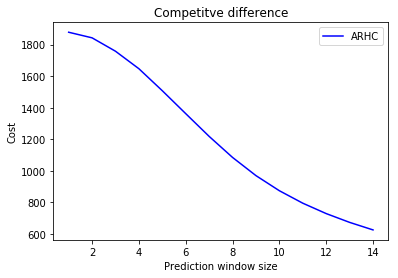

In [22]:
w = np.arange(start,end)
plt.figure()
plt.title('Competitve difference')
plt.xlabel('Prediction window size')
plt.ylabel('Cost')
plt.plot(w,f_AFHC-f_OPT,'-b',label='ARHC')
plt.legend()
plt.show()

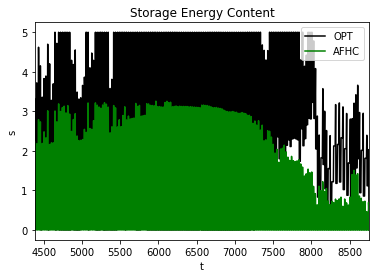

In [23]:
tau = np.arange(0,T)
plt.figure()
plt.title('Storage Energy Content')
plt.xlabel('t')
plt.ylabel('s')
plt.xlim(T/2,T)
plt.plot(tau,x_OPT,'-k',label='OPT')
plt.plot(tau,x_AFHC[-1],'-g',label='AFHC')
plt.legend()
plt.show()